In [2]:
import cv2
import numpy as np
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [3]:
from ezflow.data import DataloaderCreator
from ezflow.models import build_model
from nnflow import CustomDataloaderCreator, flow_to_image
from nnflow.inference import endpointerror

___

In [4]:
def denorm(img, mean = (127.5, 127.5, 127.5), std=(127.5, 127.5, 127.5)):
    img = img.squeeze()
    for channel in range(3):
        img[channel] = img[channel]*std[channel] + mean[channel]

    img = img.unsqueeze(dim=0)
    return img

In [139]:
def plot_frames_grid(video_frames, figsize=(12,8)):
    video_frames = torch.from_numpy(video_frames.numpy().astype(np.uint8))
    video_frames = video_frames.permute(0,3,1,2)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(make_grid(video_frames, nrow=8).permute((1, 2, 0)))

In [131]:
def plot_flow_grid(flows, figsize=(12,8)):
    flows = flows.numpy()
    flow_color = []
    for flow in flows:
        flow = flow_to_image(flow)
        flow_color.append(flow)
        
    flow_color = np.asarray(flow_color)
    flow_color = torch.from_numpy(flow_color)
    flow_color = flow_color.permute(0,3,1,2)
    grid = make_grid(flow_color, nrow=8).permute((1, 2, 0))
    
    plt.figure(figsize=figsize, dpi=120)
    plt.axis('off')
    plt.imshow(grid)

In [132]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

___

In [133]:
val_loader = CustomDataloaderCreator(batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

In [134]:
# val_loader.add_MPISintel(
#         root_dir="../../../../Datasets/MPI_Sintel/",
#         split="training",
#         dstype="clean",
#         crop=True,
#         crop_type="center",
#         crop_size=[368, 496],
#         augment=False,
#         norm_params={"use":True, "mean":[127.5, 127.5, 127.5], "std":[127.5, 127.5, 127.5]}
#     )

In [135]:
val_loader.add_Kubric(
    root_dir="../../KubricFlow",
    split="validation",
    crop=False,
    crop_type="center",
    crop_size=[256,256],
    augment=False,
    norm_params= {"use":True, "mean":[127.5, 127.5, 127.5], "std":[127.5, 127.5, 127.5]}
)

In [136]:
dl = val_loader.get_dataloader()

Total image pairs loaded: 3381/3381



In [141]:
dl_iter = iter(dl)
(img1, img2), flow_gt = (None, None), None
for i in range(0,56):
    (img1, img2), flow_gt = next(dl_iter)
    
img1.shape, img2.shape, flow_gt.shape

(torch.Size([1, 3, 512, 512]),
 torch.Size([1, 3, 512, 512]),
 torch.Size([1, 2, 512, 512]))

___

In [13]:
model = build_model("RAFT", cfg_path="../configs/raft/models/raft.yaml", custom_cfg=True)

In [14]:
state_dict = torch.load("../../results/raft/ckpts/exp01/raft_best.pth", map_location=torch.device('cpu'))

In [15]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
model.eval()
print()

In [142]:
output = model(img1, img2)

In [143]:
output["flow_upsampled"].shape

torch.Size([1, 2, 512, 512])

In [144]:
flow_pred = output["flow_upsampled"].detach()

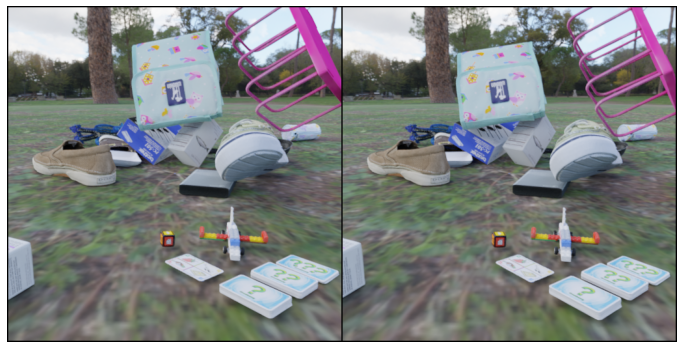

In [145]:
_img1, _img2 = denorm(img1), denorm(img2)
frames = torch.cat([_img1, _img2],dim=0)
plot_frames_grid(frames.permute(0,2,3,1))

In [146]:
new_flow_gt = torch.zeros(flow_gt.shape)

# Swap column major to row_major
new_flow_gt[:,0,:,:] = flow_gt[:,1,:,:]
new_flow_gt[:,1,:,:] = flow_gt[:,0,:,:]

new_flow_gt.shape

torch.Size([1, 2, 512, 512])

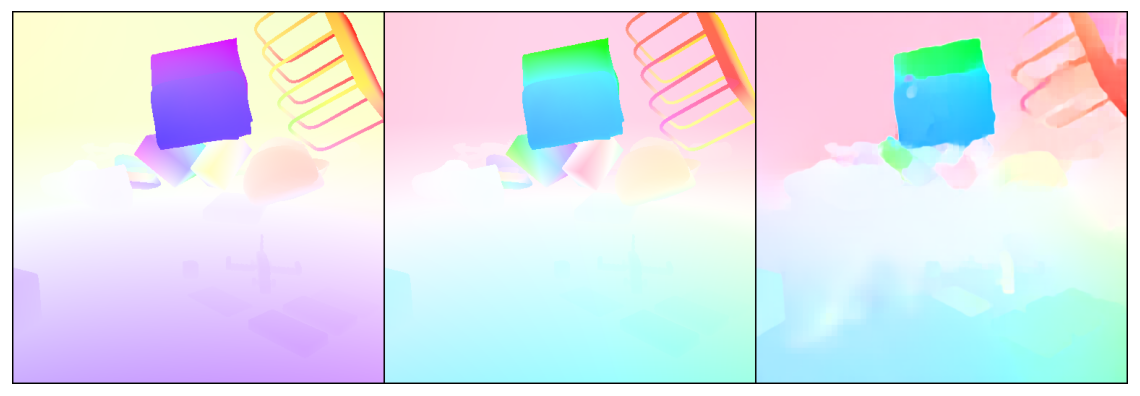

In [147]:
flow_frames = torch.cat([flow_gt, new_flow_gt, flow_pred], dim=0)
plot_flow_grid(flow_frames.permute(0,2,3,1))

In [148]:
old_epe = endpointerror(flow_pred, flow_gt)
new_epe = endpointerror(flow_pred, new_flow_gt)

print(f"old epe: {old_epe}")
print(f"new epe: {new_epe}")

old epe: {'epe': 8.072019577026367}
new epe: {'epe': 1.3389102220535278}


___

In [149]:
def point_vec(img,flow):
    meshgrid = np.meshgrid(range(img.shape[1]),range(img.shape[0]))
    dispimg = cv2.resize(img, None,fx=4,fy=4)
    colorflow = flow_to_image(flow).astype(int)
    for i in range(img.shape[1]): # x 
        for j in range(img.shape[0]): # y
            # if flow[j,i,2] != 1: continue
            if j%10!=0 or i%10!=0: continue
            xend = int((meshgrid[0][j,i]+flow[j,i,0])*4)
            yend = int((meshgrid[1][j,i]+flow[j,i,1])*4)
            leng = np.linalg.norm(flow[j,i,:2])
            if leng<1:continue
            dispimg = cv2.arrowedLine(dispimg, (meshgrid[0][j,i]*4,meshgrid[1][j,i]*4),\
                                      (xend,yend),
                                      (int(colorflow[j,i,2]),int(colorflow[j,i,1]),int(colorflow[j,i,0])),3,tipLength=8/leng,line_type=cv2.LINE_AA)
    return dispimg 

In [150]:
img = _img1.squeeze().permute(1,2,0).numpy()
img.shape

(512, 512, 3)

In [163]:
flow_pred_vec = flow_pred.squeeze().permute(1,2,0).numpy()
flow_gt_vec = flow_gt.squeeze().permute(1,2,0).numpy()
new_flow_gt_vec = new_flow_gt.squeeze().permute(1,2,0).numpy()

In [164]:
flow_vec_pred = torch.from_numpy(point_vec(img,flow_pred_vec)).unsqueeze(dim=0)
flow_vec_gt = torch.from_numpy(point_vec(img, flow_gt_vec)).unsqueeze(dim=0)
new_flow_gt_vec = torch.from_numpy(point_vec(img, new_flow_gt_vec)).unsqueeze(dim=0)

In [166]:
flow_vec_gt.shape, new_flow_gt_vec.shape, flow_vec_pred.shape

(torch.Size([1, 2048, 2048, 3]),
 torch.Size([1, 2048, 2048, 3]),
 torch.Size([1, 2048, 2048, 3]))

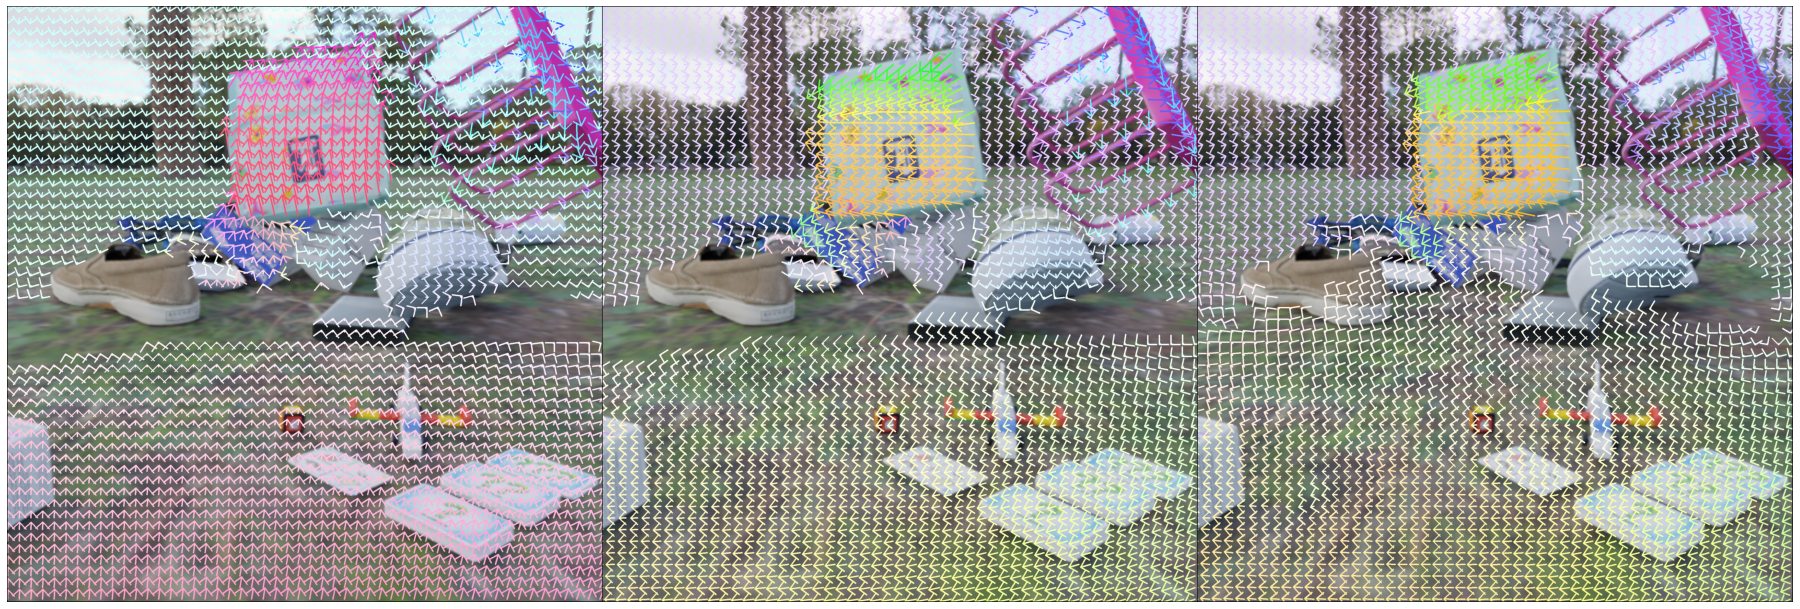

In [170]:
flow_frames = torch.cat([flow_vec_gt, new_flow_gt_vec, flow_vec_pred], dim=0)
plot_frames_grid(flow_frames, figsize=(32,32))

In [171]:
old_epe = endpointerror(flow_pred, flow_gt)
new_epe = endpointerror(flow_pred, new_flow_gt)

print(f"old epe: {old_epe}")
print(f"new epe: {new_epe}")

old epe: {'epe': 8.072019577026367}
new epe: {'epe': 1.3389102220535278}
